In [66]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math

from radiometric.LUT import create_LUT_df, determine_reference, applyNUC_to_LUT

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq


In [67]:
#choose filepath to desired data
path = '/Volumes/KESU/may19/polarized/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [68]:
waves= np.linspace(7,12,61)
temps = np.linspace(0,359,360)

In [69]:
#select ROI
ymin2 = 90; ymax2 = 150;
ymin1 = 120; ymax1 = 180;

FOV = 5.33 ;
HFOV = FOV/4;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

In [70]:
#load LUTS

with h5py.File('/Volumes/KESU/apr06/LUTS/LUT.h5', "r") as file:
    var = file['/var'][()]
    var1 = file['/var1'][()]
    var2 = file['/var2'][()]
    
    waves = file['/waves'][()]
    nedt =  file['/nedt'][()]

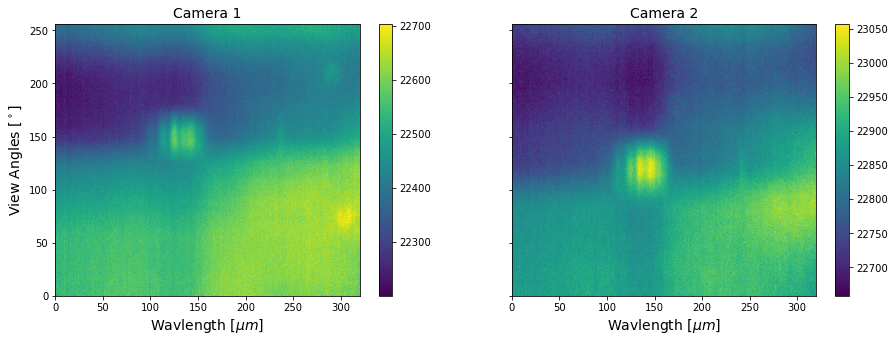

In [71]:
filename = path + '10deg.h5'


with h5py.File(filename, "r") as file:
    image1 = np.mean(file['imgs1'][()],axis = 0)
    image2 = np.mean(file['imgs2'][()],axis = 0)
    s1 = np.std(file['imgs1'][()],axis = 0)
    s2 = np.mean(file['imgs2'][()],axis = 0)
    t2 = np.mean(file['temps2'][()],axis = 0)
    t1 = np.mean(file['temps1'][()],axis = 0)

c1 = (image1-np.mean(image1[125:175,25:75]))

c2 = (image2-np.mean(image2[100:150,25:75]))

r1 = np.mean(image1[100:150,25:75])

#plot test images, test appearance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)

p1 = axes[0].pcolormesh(image1,shading = 'auto')#,vmin = 0)
fig.colorbar(p1, ax=axes[0])
axes[0].set_title('Camera 1',fontsize = 14)
axes[0].set_ylabel('View Angles [$^\circ$]',fontsize = 14)
axes[0].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)

p2 = axes[1].pcolormesh(image2,shading = 'auto')#,vmin = 0)
axes[1].set_title('Camera 2',fontsize = 14)
axes[1].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)
fig.colorbar(p2, ax=axes[1])

plt.show()

In [72]:
im1 = []
im2 = []
std1 = []
std2 = []
for t in temps:
    filename = path +str(round(t))+'deg.h5'

    with h5py.File(filename, "r") as file:
        image1 = np.mean(file['imgs1'][()],axis = 0)
        image2 = np.mean(file['imgs2'][()],axis = 0)
        s1 = np.std(file['imgs1'][()],axis = 0)
        s2 = np.std(file['imgs2'][()],axis = 0)


    c1 = (image1-np.mean(image1[125:175,25:75]))
    c2 = (image2-np.mean(image2[100:150,25:75]))
    
    im1.append(c1)
    im2.append(c2)
    std1.append(s1)
    std2.append(s2)



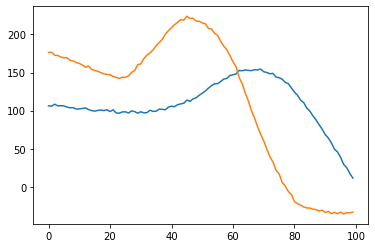

In [73]:
#Find location of 0 degree point
p2 = pixel_registration(im2[1],cal_file2,waves,50,150)
p1 = pixel_registration(im1[1],cal_file1,waves,100,200)
plt.plot(np.mean(p2,axis = 1))
plt.plot(np.mean(p1,axis = 1))
plt.show()

y1 = 142
y2 = 119

In [74]:
responses = np.zeros([len(temps),len(waves)])
responses1 = np.zeros([len(temps),len(waves)])
responses2 = np.zeros([len(temps),len(waves)])
responses_err = np.zeros([len(temps),len(waves)])
responses_err1 = np.zeros([len(temps),len(waves)])
responses_err2 = np.zeros([len(temps),len(waves)])

for t in range(len(temps)):
    p2 = pixel_registration(im2[t],cal_file2,waves,0,256)
    p1 = pixel_registration(im1[t],cal_file1,waves,0,256)
    s2 = pixel_registration(std2[t],cal_file2,waves,0,256)
    s1 = pixel_registration(std1[t],cal_file1,waves,0,256)

    err = np.sqrt((s2[y2]/p2[y2])**2+(s1[y1]/p1[y1])**2)
    responses[t]= (p1[y1]+p2[y2])
    responses_err[t]= err
    
    responses1[t]= p1[y1]
    responses_err1[t]= s1[y1]
    responses2[t]= p2[y2]
    responses_err2[t]= s2[y2]


In [76]:
hf = h5py.File(path + 'poldata.h5', 'w')
hf.create_dataset('/var', data=var)
hf.create_dataset('/var1', data=var)
hf.create_dataset('/var2', data=var)
hf.create_dataset('/nedt', data=nedt)

hf.create_dataset('/responses1', data=responses1)
hf.create_dataset('/responses2', data=responses2)
hf.create_dataset('/responses_err1', data=responses_err1)
hf.create_dataset('/responses_err2', data=responses_err2)
    
hf.create_dataset('/waves',data = waves)
hf.create_dataset('/angles', data = temps)

hf.close()

In [672]:
def func(x, a, b,c):
    y = a * np.cos(x*2* np.pi/180 + b) +c
    return y

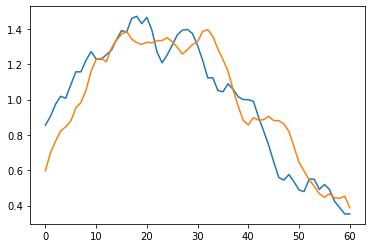

In [678]:
plt.plot(responses1[10]/np.mean(responses1[10]))
plt.plot(responses2[10]/np.mean(responses2[10]))